
# Speech Analysis on European Languages and Next Word Prediction

**Language chosen - French**

**Note - Originally intended to run on Spanish speaker data however due to the presence of currupt audio files, French dataset was chosen instead**

**Getting rid of warnings**

In [1]:
!pip install shutup

In [2]:
import shutup; shutup.please()

# Environmental Setup

Follow the next steps to open the notebook in colab environment

**Kaggle API Token for Google Colab**

In [3]:
!pip install kaggle

In [4]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download bryanpark/french-single-speaker-speech-dataset

In [6]:
!unzip *.zip

# Importing Required Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import nltk
import librosa
import librosa.display
import tensorflow as tf
import re
import os
import string
from nltk.corpus import stopwords
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [8]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  all


       | 
       | Downloading package abc to /usr/share/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /usr/share/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package averaged_perceptron_tagger to
       |     /usr/share/nltk_data...
       |   Package averaged_perceptron_tagger is already up-to-date!
       | Downloading package averaged_perceptron_tagger_ru to
       |     /usr/share/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to
       |     /usr/share/nltk_data...
       |   Package basque_grammars is already up-to-date!
       | Downloading package biocreative_ppi to
       |     /usr/share/nltk_data...
       |   Package biocreative_ppi is already up-to-date!
       | Downloading package bllip_wsj_no_aux to
       |     /usr/share/nltk_data...
       |   Package bllip_wsj_no_aux is already up-to-date!
       | Down


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  q


True

**Loading the data**

In [9]:
dataframe = pd.read_csv('../input/french-single-speaker-speech-dataset/transcript.txt', sep='|', header=None)

In [10]:
dataframe.columns = ["Wave_file","Messages","Transcript","Audio Length"]

In [11]:
dataframe["Wave_file"] = "../input/french-single-speaker-speech-dataset/" + dataframe["Wave_file"]

In [12]:
dataframe.head()

,Wave_file,Messages,Transcript,Audio Length
0,../input/french-single-speaker-speech-dataset/...,Chapitre I La Charybde du faubourg Saint-Antoi...,Chapitre I La Charybde du faubourg Saint-Antoi...,7.63
1,../input/french-single-speaker-speech-dataset/...,Les deux plus mémorables barricades que l'obse...,Les deux plus mémorables barricades que l'obse...,9.41
2,../input/french-single-speaker-speech-dataset/...,"Ces deux barricades, symboles toutes les deux,...","Ces deux barricades, symboles toutes les deux,...",6.27
3,../input/french-single-speaker-speech-dataset/...,sortirent de terre lors de la fatale insurrect...,sortirent de terre lors de la fatale insurrect...,9.24
4,../input/french-single-speaker-speech-dataset/...,"Il arrive quelquefois que, même contre les pri...","Il arrive quelquefois que, même contre les pri...",6.54


In [13]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
Audio Length,8649.0,7.971208,2.089509,1.01,6.81,8.23,9.24,29.61


**PreProcessing the Data**

In [14]:
stopwords = stopwords.words('french')
punct = list(string.punctuation)

**Preprocessing the data -**

Creating a data preprocessing function, that carries out a series of preprocessing operations on the dataset.

In [15]:
def data_preprocessing(dataframe):
    dataframe["Messages"] = dataframe["Messages"].apply(lambda x: re.sub('[^a-zA-Z]',' ',x))
    dataframe["Messages"] = dataframe["Messages"].apply(lambda x: x.lower())
    dataframe["Messages"] = dataframe["Messages"].apply(lambda x: x.replace("[^A-Za-z]",""))
    dataframe["Messages"] = dataframe["Messages"].apply(lambda x: x.replace("'",""))
    dataframe["Messages"] = dataframe["Messages"].apply(lambda x: x.replace("\s+"," "))
    dataframe["Messages"] = dataframe["Messages"].apply(lambda x: " ".join([word for word in x.split() if word not in punct]))
    dataframe["Messages"] = dataframe["Messages"].apply(lambda x: " ".join([word for word in x.split() if word not in stopwords and len(word)>1]))
    dataframe["Messages"] = "start "+dataframe["Messages"]+" end"
    return dataframe

In [16]:
dataframe = data_preprocessing(dataframe)
dataframe = dataframe.sample(2500,random_state = 0 )
dataframe.head()

,Wave_file,Messages,Transcript,Audio Length
7913,../input/french-single-speaker-speech-dataset/...,start videmment comment pouvait conna tre puis...,– videmment. Mais comment pouvait-il la connaî...,7.91
1811,../input/french-single-speaker-speech-dataset/...,start alise presque id al entend angleterre mo...,Il réalise presque l'idéal de ce qu'on entend ...,9.12
4923,../input/french-single-speaker-speech-dataset/...,start cet argent bien voici toute chose jais b...,cet argent est bien à toi. Voici toute la chos...,7.59
4695,../input/french-single-speaker-speech-dataset/...,start toute vie concentrait cette heure asseya...,Toute sa vie se concentrait dans cette heure-l...,4.94
7159,../input/french-single-speaker-speech-dataset/...,start deux heures pourrai quitter place apr av...,"deux heures, je pourrai moi-même quitter la pl...",9.31


**Tokenization**

In [17]:
messages = dataframe["Messages"].to_list()

In [18]:
messages = dataframe["Messages"].to_list()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(messages)
vocab_size = len(tokenizer.word_index)+1
max_length = dataframe["Messages"].apply(lambda x: len(x.split(" "))).max()

In [19]:
sequences = tokenizer.texts_to_sequences(messages)

**MFCC Feature Creation**

In [20]:
def create_mfcc_features(path):
    mfccs = []
    try:
        x , sr = librosa.load(path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)
        mfccs = np.mean(mfccs.T,axis=0)
    except:
        print('Error reading audio')
    return mfccs

In [21]:
features = []
for path in dataframe["Wave_file"]:
    x = create_mfcc_features(path)
    x = x.reshape(16, 8, 1)
    features.append(x)

# Model Creation

**Objective - Creation of a CNN Model to carry out the prediction of the following word.**

**Inputs to the Model -**
1. Audio features
2. Audio Messages


**Outputs to the Model -**
1. Next predicted word

In [22]:
X1 = []
X2 = []
y = []
j = 0
for feature in features:
    if j == 1:
        break
    seq = tokenizer.texts_to_sequences([messages[j]])[0]
    j = j+1
    for i in range(1,len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        out_seq = to_categorical([out_seq], num_classes=vocab_size)
        X1.append(feature)
        X2.append(in_seq)
        y.append(out_seq)


In [23]:
input2 = []
for i in X2:
    input2.append(tokenizer.sequences_to_texts([i]))
    
model_data = pd.DataFrame()
model_data["mfcc_features"] = X1
model_data["input_messages"]= input2
model_data["outputs"] = y

In [24]:
model_data.head()

,mfcc_features,input_messages,outputs
0,"[[[-364.45276], [89.522064], [-9.886822], [30....",[start],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[[[-364.45276], [89.522064], [-9.886822], [30....",[start videmment],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[[[-364.45276], [89.522064], [-9.886822], [30....",[start videmment comment],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"[[[-364.45276], [89.522064], [-9.886822], [30....",[start videmment comment pouvait],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,"[[[-364.45276], [89.522064], [-9.886822], [30....",[start videmment comment pouvait conna],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,..."


**Feature creation for all files**

In [25]:
X1 = []
X2 = []
y = []
j = 0
for feature in features:
    if j == 2000:
        break
    seq = tokenizer.texts_to_sequences([messages[j]])[0]
    j = j+1
    for i in range(1,len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        in_seq = pad_sequences([in_seq], maxlen=max_length)
        out_seq = to_categorical([out_seq], num_classes=vocab_size)
        X1.append(feature)
        X2.append(in_seq)
        y.append(out_seq)
X1 = np.array(X1)
X2 = np.array(X2)
y = np.array(y)

In [26]:
X1.shape,X2.shape,y.shape

((23373, 16, 8, 1), (23373, 1, 45), (23373, 1, 7213))

In [27]:
X2 = X2.reshape(23373,45)
y = y.reshape(23373,7213)

In [28]:
final_dataframe = pd.DataFrame({"X1": list(X1),"X2":list(X2),"y":list(y)})

In [29]:
final_dataframe.head()

,X1,X2,y
0,"[[[-364.45276], [89.522064], [-9.886822], [30....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[[[-364.45276], [89.522064], [-9.886822], [30....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[[-364.45276], [89.522064], [-9.886822], [30....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[[-364.45276], [89.522064], [-9.886822], [30....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[[-364.45276], [89.522064], [-9.886822], [30....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


In [30]:
wave_file = dataframe["Wave_file"].to_list()

In [31]:
split = int(len(messages)*0.8)
X_train = [X1[:split],X2[:split]]
y_train = y[:split]
X_test = [X1[split:],X2[split:]]
y_test = y[split:]

**Model Creation**

The created CNN model will be run 2 times.

Once for making predictions on training data and second time for making predictions on validation data.

In [32]:
input1 = Input(shape=(16,8,1))
input2 = Input(shape=(max_length,))

feature_model = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = "same")(input1)
feature_model = MaxPooling2D(2, 2)(feature_model)
feature_model = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding = "same")(feature_model)
feature_model = MaxPooling2D(2, 2)(feature_model)
feature_model = Flatten()(feature_model)
feature_model = Dense(128, activation='relu')(feature_model)
feature_model_reshaped = Reshape((1, 128), input_shape=(128,))(feature_model)

prompt_features = Embedding(vocab_size, 128, mask_zero=False)(input2)
prompt_features = LSTM(128)(prompt_features)
prompt_features = Dropout(0.5)(prompt_features)

x = add([prompt_features, feature_model])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)



2022-10-16 09:56:18.111835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 09:56:18.232553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 09:56:18.233801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 09:56:18.518677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**Invoking Model**

In [33]:
prediction_model = Model(inputs=[input1,input2], outputs=output)

**Compiling Model**

In [34]:
prediction_model.compile(loss='categorical_crossentropy',optimizer='Nadam')

**Visualising Model Summary**

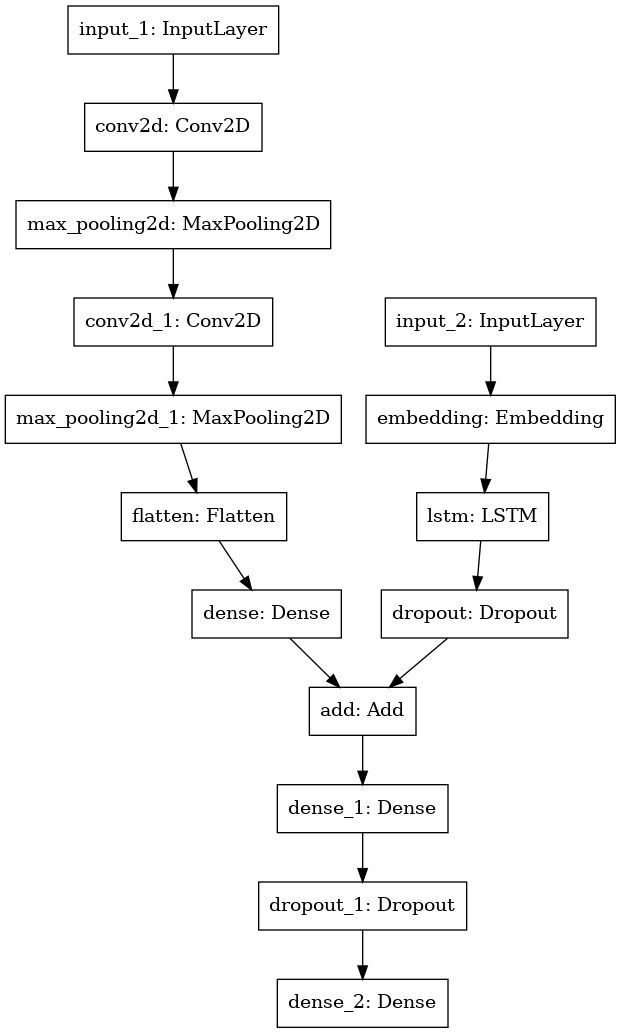

In [35]:
plot_model(prediction_model)

**Fitting the Model**

In [36]:
history = prediction_model.fit(X_train,y_train,
        epochs=50,
        batch_size = 32,
        validation_data=(X_test,y_test),
        validation_batch_size = 32)

2022-10-16 09:56:22.576544: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-10-16 09:56:25.500964: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


60/63 [===========================>..] - ETA: 0s - loss: 8.3902

2022-10-16 09:56:32.371236: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 616653796 exceeds 10% of free system memory.
2022-10-16 09:56:33.106871: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 616653796 exceeds 10% of free system memory.


63/63 [==============================] - 14s 76ms/step - loss: 8.3605 - val_loss: 7.9350
Epoch 2/50
63/63 [==============================] - 3s 43ms/step - loss: 7.3903 - val_loss: 7.9543
Epoch 3/50
63/63 [==============================] - 3s 46ms/step - loss: 7.1081 - val_loss: 7.9861
Epoch 4/50
63/63 [==============================] - 3s 43ms/step - loss: 6.9230 - val_loss: 8.5649
Epoch 5/50
63/63 [==============================] - 3s 42ms/step - loss: 6.7895 - val_loss: 8.3267
Epoch 6/50
63/63 [==============================] - 3s 43ms/step - loss: 6.6780 - val_loss: 8.3312
Epoch 7/50
63/63 [==============================] - 3s 45ms/step - loss: 6.5275 - val_loss: 9.1683
Epoch 8/50
63/63 [==============================] - 3s 42ms/step - loss: 6.4034 - val_loss: 8.9046
Epoch 9/50
63/63 [==============================] - 3s 42ms/step - loss: 6.2565 - val_loss: 9.0379
Epoch 10/50
63/63 [==============================] - 3s 42ms/step - loss: 6.1088 - val_loss: 9.0600
Epoch 11/50
63/63 [

**Model Predictions**

In [37]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

**Evaluation on Training Data**

In [38]:
for j in range(10):
    in_text = "start"
    feature = create_mfcc_features(wave_file[j])
    feature = feature.reshape(1,16,8,1)
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = prediction_model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'end':
            break
    print("Actual text :",messages[j])
    print("Predicted text :",in_text)
    print("\n")

Actual text : start videmment comment pouvait conna tre puisque hasard canisme secret cette lampe end
Predicted text : start videmment pouvait conna re conna tre puisque hasard secret lampe end


Actual text : start alise presque id al entend angleterre mot respectable convenable gris tre end
Predicted text : start alise presque entend entend angleterre respectable convenable convenable convenable end


Actual text : start cet argent bien voici toute chose jais blanc vient norv ge end
Predicted text : start argent valjean argent valjean jais jais blanc vient norv ge end


Actual text : start toute vie concentrait cette heure asseyait pr end
Predicted text : start toute valjean concentrait concentrait valjean asseyait end


Actual text : start deux heures pourrai quitter place apr avoir enlev derniers vestiges installation petite affaire end
Predicted text : start heures pourrai pourrai pourrai place apr apr apr avoir enlev derniers installation affaire end


Actual text : start sol tai

**Validation Data Evaluation**

In [39]:
for j in range(1800,1810):
    in_text = "start"
    feature = create_mfcc_features(wave_file[j])
    feature = feature.reshape(1,16,8,1)
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = prediction_model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'end':
            break
    print("Actual text :",messages[j])
    print("Predicted text :",in_text)
    print("\n")

Actual text : start trouvait nouveau face tres prot ars lupin sous action directe influence end
Predicted text : start seul taillant cessaire comme municipalit comme affaires neuilly end


Actual text : start voir entrer autres posta aguets derri re tas blais rage patiente chien arr end
Predicted text : start continue existe papiers hoche capitula rostiers fleurus end


Actual text : start dix derniers si cles travaill sans pouvoir terminer plus pu finir paris end
Predicted text : start droit pourrai pourrai assis tait mis valjean envie reprit gratis end


Actual text : start encore encombr sens dessus dessous air champ bataille joies veille end
Predicted text : start mot cette vu sang sang joie supr end


Actual text : start ressemblait sens marchait comme instant cygnes nageaient end
Predicted text : start fini admet progr sublime songent end


Actual text : start ob issance ici consistait souvenir marius oubliait aucun effort faire cela end
Predicted text : start tait born peu tait 

**As we can see the predicted text is not yielding satisfactory results and may be the result of one of the following reasons -**

1. Inadequate samples for training
2. Requirement of a better model
3. Probable use of SOTA models